# 📊 Data Analysis Report for Rice Leaf Disease Dataset

---

## 1. 📂 Dataset Overview

The dataset consists of **119 images** of rice leaves categorized into three classes:

- **Bacterial Leaf Blight**: 40 images  
- **Brown Spot**: 40 images  
- **Leaf Smut**: 39 images  

These images are collected from infected rice plants, each showing distinct symptoms. The objective is to classify these images into the correct disease categories.

---

## 2. 🧾 Dataset Characteristics

- **Small dataset size**: Only 119 images, which is limited for deep learning.  
- **Class distribution**: Nearly balanced (around 40 images per class).  
- **Image quality**: Varies in lighting, background, and leaf orientation.  
- **Image format**: RGB images with 3 color channels (important for disease spot detection).

---

## 3. ⚠️ Challenges with the Dataset

- **Limited sample size** → Higher risk of overfitting.  
- **Variability** → Differences in angles, lighting, and background make learning harder.  
- **Visual similarity** → Some diseases look quite similar, leading to possible misclassification.

---

## 4. 🛠️ Data Preprocessing & Cleaning

- **Resizing** → All images resized to a uniform size (e.g., 255x255 pixels).  
- **Normalization** → Pixel values scaled between 0 and 1.  
- **Shuffling and batching** → Applied for better training and to avoid bias.

---

## 5. 🔁 Data Augmentation

To improve model performance and reduce overfitting, augmentation techniques were used:

- Random **horizontal/vertical flips**  
- Random **rotations**  
- These simulate real-world variations and help the model generalize better.

---

## 6. 🔎 Exploratory Data Analysis (EDA)

- **Class count visualization** → Checked if data is balanced.  
- **Sample visualization** → Displayed images from each class to understand appearance.  
- **Label verification** → Ensured correct labeling of images.

---

## 7. ✅ Summary & Insights

- Dataset is small but usable for training with augmentation and preprocessing.  
- Data augmentation is **necessary** to improve learning and generalization.  
- Preprocessing brings uniformity to image inputs.  
- **Deep models or transfer learning** may be required due to visual similarity between disease classes.

---



## Importing Libraries and Mount drive to Import Images dataset

In [1]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
# set all the constants(hyperparameters)
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20
from google.colab import drive
drive.mount('/content/drive')

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Data',  # or your actual path here
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Mounted at /content/drive
Found 119 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

## Label :-
#### This part shows the labels corresponding to the images in the batch. It's a 1D tensor with a shape of (32), indicating the label for each image in the batch. The labels seem to be integers, ranging from 0 to 2

In [5]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Single Image :  tf.Tensor(
[[[233.40111 218.40111 211.40111]
  [233.15294 221.63528 215.63528]
  [229.55293 218.77646 209.29411]
  ...
  [224.73552 207.73552 200.73552]
  [225.74118 208.74118 201.74118]
  [227.45874 210.45874 200.9764 ]]

 [[232.42021 217.42021 210.42021]
  [231.59999 218.59999 212.59999]
  [232.77647 219.77647 211.77647]
  ...
  [225.77647 208.77647 201.77647]
  [226.22353 209.22353 202.22353]
  [227.57973 210.57973 202.57973]]

 [[233.29411 220.29411 214.29411]
  [232.55986 217.55986 212.55986]
  [232.70589 217.70589 212.70589]
  ...
  [225.79234 208.79234 201.79234]
  [226.52249 208.52249 204.52249]
  [226.      212.      203.     ]]

 ...

 [[234.89479 220.16469 215.02974]
  [234.11073 219.11073 214.11073]
  [234.79237 219.79237 214.79237]
  ...
  [228.41498 210.12085 201.00323]
  [229.1834  210.1834  203.88927]
  [228.      209.      202.     ]]

 [[234.1849  219.1849  214.1849 ]
  [233.77649 219.22351 214.     ]
  [235.     

In [6]:
len(class_names)

3

# EDA :-
## Visualize some of the images from our dataset

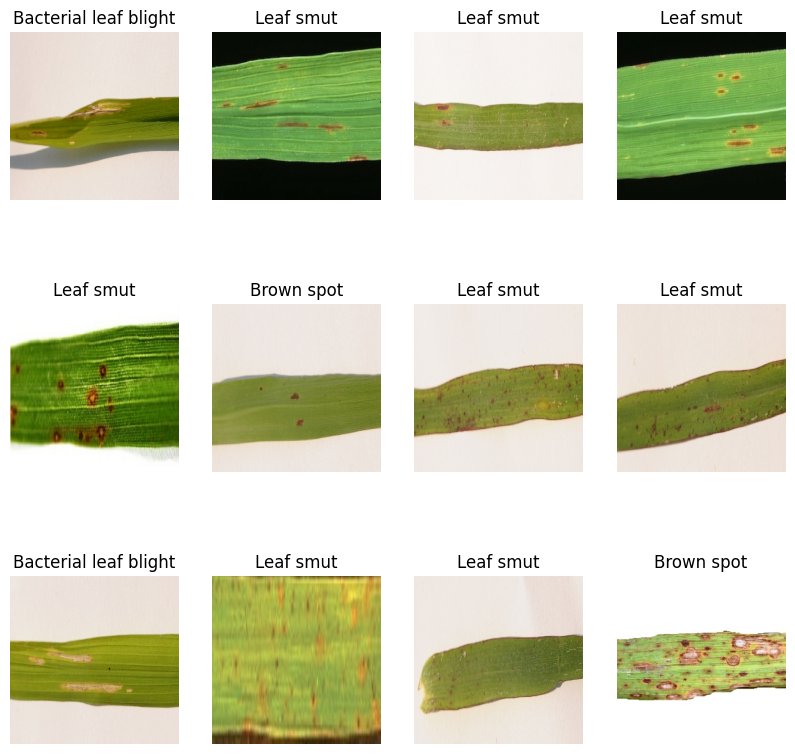

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset
### Dataset should be bifurcated into 3 subsets, namely:

##### Training: Dataset to be used while training
##### Validation: Dataset to be tested against while training
##### Test: Dataset to be tested against after we trained a model

In [8]:
total_batches = len(dataset)

train_size = max(1, int(0.7 * total_batches))
val_size = max(1, int(0.2 * total_batches))
test_size = total_batches - train_size - val_size

# Adjust again if needed
if test_size <= 0:
    test_size = 1
    train_size = total_batches - val_size - test_size

# Split dataset
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

# Print sizes
print(f"Train batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Train batches: 2
Validation batches: 1
Test batches: 1


##Building the Model
#### Creating a Layer for Resizing and Normalization Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

#### You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Changed from layers.preprocessing.Resizing
  layers.Rescaling(1./255), # Changed from layers.preprocessing.Rescaling
])

# 📊 Data Augmentation Report

## 📝 Why Data Augmentation Was Used

In this project, the dataset consists of only **119 total images** across **three classes**:

- 40 images of **Bacterial Leaf Blight**
- 40 images of **Brown Spot**
- 39 images of **Leaf Smut**

This is a very small dataset for training a deep learning model. If trained without augmentation, the model would likely:

- Overfit to the small training set
- Fail to generalize on new or unseen images
- Show poor validation and test accuracy

To overcome this, **data augmentation** was applied.

In [11]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [12]:
for batch in val_ds.take(1):
    print("Validation batch found.")

for images, labels in val_ds.take(1):
    print(f"Validation batch shape: {images.shape}")

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Validation batch found.
Validation batch shape: (32, 255, 255, 3)


In [13]:
print(f"Train batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")

Train batches: 2
Validation batches: 1


# Model Architecture

#### We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [14]:
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [15]:
print(f"Length of train_ds: {len(train_ds)}")
print(f"Length of val_ds: {len(val_ds)}")
print(f"Length of test_ds: {len(test_ds)}")

if len(val_ds) == 0:
    print("Warning: val_ds is empty. Validation metrics will not be available.")

Length of train_ds: 2
Length of val_ds: 1
Length of test_ds: 1


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [17]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Use this if your labels are integers
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,  # Ensure val_ds is not None
    epochs=85,
    verbose=1,
)

Epoch 1/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2917 - loss: 1.0992 - val_accuracy: 0.4062 - val_loss: 1.0916
Epoch 2/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 0.3021 - loss: 1.0940 - val_accuracy: 0.4062 - val_loss: 1.0823
Epoch 3/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.3958 - loss: 1.0971 - val_accuracy: 0.4062 - val_loss: 1.0895
Epoch 4/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - accuracy: 0.3646 - loss: 1.0910 - val_accuracy: 0.4062 - val_loss: 1.0834
Epoch 5/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - accuracy: 0.3958 - loss: 1.0828 - val_accuracy: 0.4375 - val_loss: 1.0825
Epoch 6/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.4167 - loss: 1.0774 - val_accuracy: 0.5000 - val_loss: 1.0807
Epoch 7/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - accuracy: 0.4375 - loss: 1.0797 - val_accuracy: 0.5000 - val_loss: 1.0682
Epoch 8/85
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - accuracy: 0.4688 - loss: 1.0606 - val_accuracy: 0.4062 - val_loss: 1

In [19]:
scores = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8261 - loss: 0.7240


In [20]:
model.save("model.h5")

## Plotting the Accuracy and Loss Curves

In [21]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 85, 'steps': 2}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [22]:
print("Available history keys:", history.history.keys())
if len(val_ds) == 0:
    print("⚠️ Warning: Validation dataset is empty. No validation accuracy/loss will be recorded.")
history.history['loss'][:5] # show loss for first 5 epochs

Available history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


[1.0992636680603027,
 1.0927624702453613,
 1.1103135347366333,
 1.089903473854065,
 1.0853068828582764]

In [23]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

loss = history.history['loss']
# val_loss = history.history['val_loss']

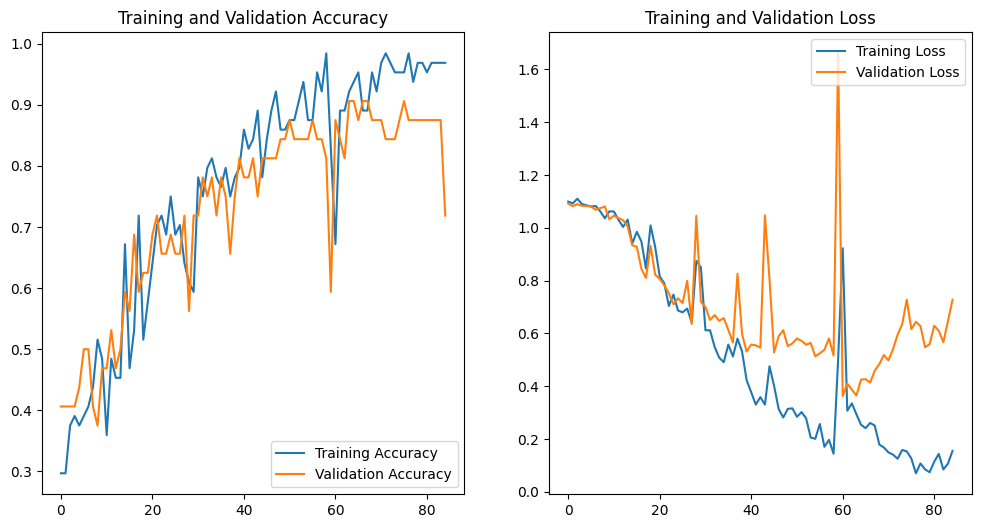

In [24]:
acc = history.history['accuracy']
val_acc = history.history.get('val_accuracy')  # use .get() in case it's None

loss = history.history['loss']
val_loss = history.history.get('val_loss')

epochs_range = range(len(acc))  # will automatically match the number of trained epochs

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
if val_acc:
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
if val_loss:
    plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Run prediction on a sample image

In [25]:
model = tf.keras.models.load_model('model.h5')

first image to predict
actual label: Bacterial leaf blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
predicted label: Bacterial leaf blight


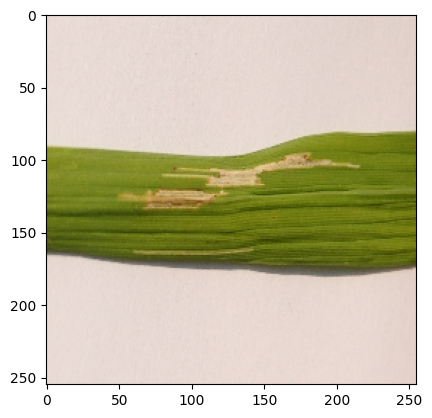

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# 🧠 Inference Report

## 📝 Why Inference Was Used

After training the model on a small dataset, inference was done to check how well the model predicts new, unseen images.

## 🔍 What Inference Does

- Predicts classes for new images using the trained model  
- Provides confidence scores for each prediction  
- Helps verify model accuracy on test data

## ✅ Benefits of Inference

- Confirms model’s real-world performance  
- Shows actual vs predicted results  
- Measures prediction confidence


## Function for inference

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


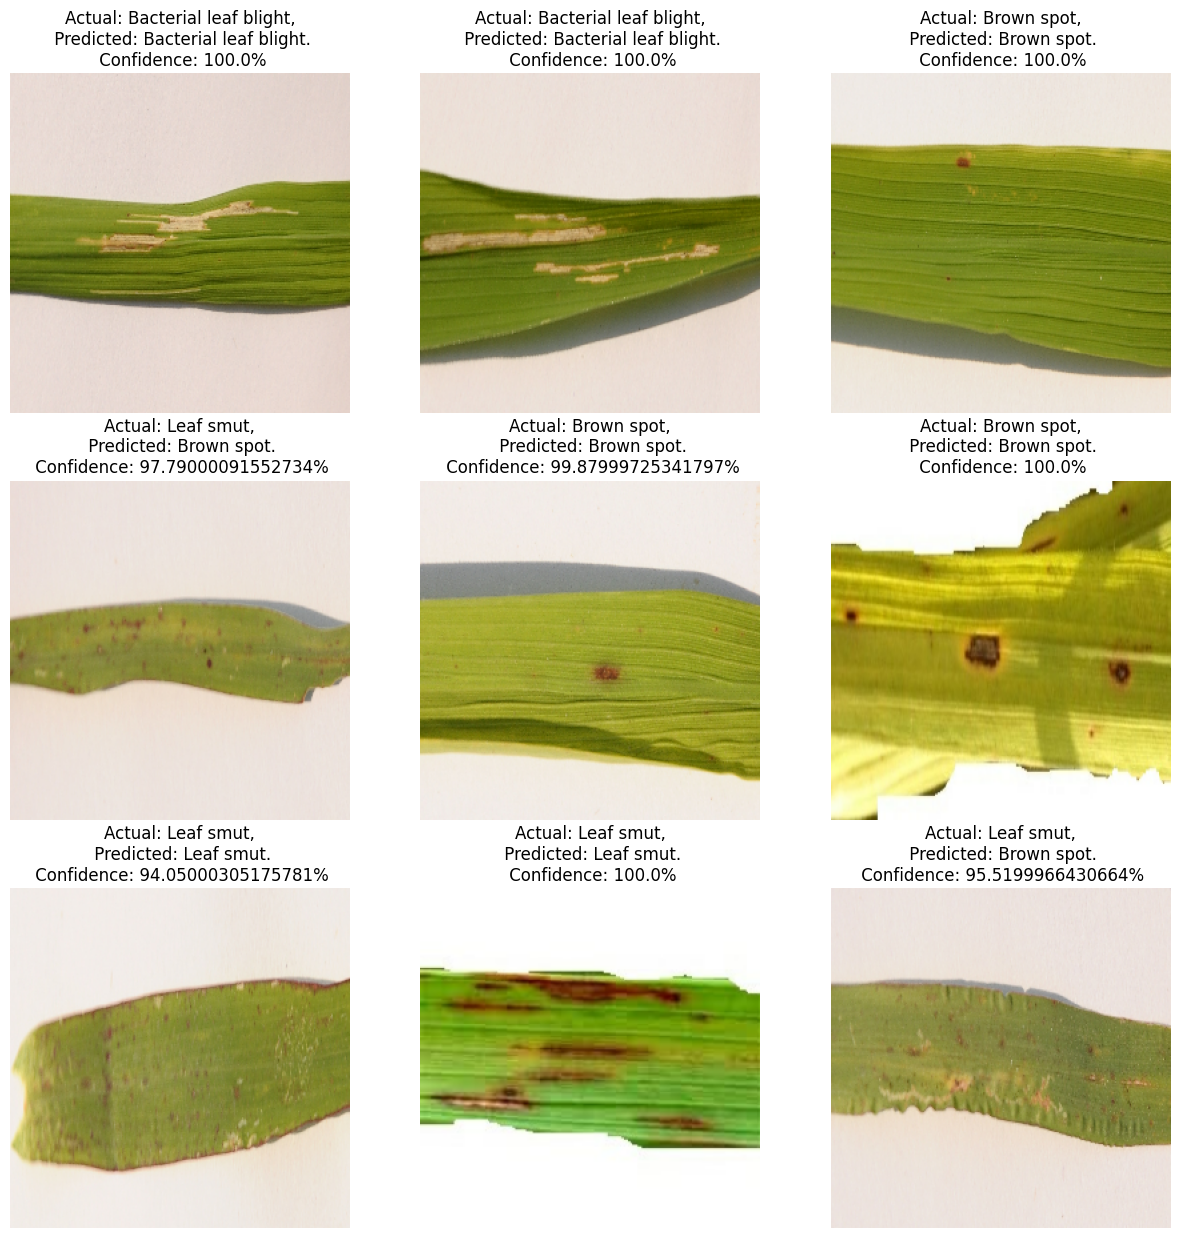

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [29]:
model.save("Plant_leaf_diseases_detection_model.h5")